In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib.dates as mdates
from sklearn.model_selection import ParameterGrid, train_test_split
from datetime import datetime, timedelta
import calendar as calendar
import datetime
sb.set()

In [2]:
df = pd.read_csv('carpark_availability_cleaned.csv')
holidays_df = pd.read_csv('sg_holidays.csv')
carpark_info = pd.read_csv('carpark_info_cleaned.csv')

In [3]:
carpark_arr = df.carpark_number.unique()

In [4]:


tempDf = df.copy()
tempDf.insert(0, 'id', range(0, len(tempDf)))

trainDf = pd.DataFrame()
# Split Data based on individual carpark, day and hour
for carpark_num in range(len(carpark_arr)):
    print("Parsing " + carpark_arr[carpark_num])
    for days in range(0,7):
        for hours in range(0,24):
            trainDf = pd.concat([trainDf, 
                                 tempDf[(tempDf['carpark_number'] == 
                                 carpark_arr[carpark_num]) & (tempDf['day'] == days) & (tempDf['hour'] == hours)].sample(frac=0.8,random_state=500)]) # Train
#     trainDf = pd.concat([trainDf, tempDf[(tempDf['carpark_number'] == carpark_arr[carpark_num])].sample(frac=0.8,random_state=500)]) # Train
print("Completed")



Parsing J70
Parsing J85M
Parsing J72
Parsing J69
Parsing JM31
Parsing J62M
Parsing J63
Parsing J83M
Parsing J67
Parsing JM2
Completed


In [5]:


trainDf.head(5)



,id,carpark_number,update_datetime,total_lots,lots_available,hour_delta,day,hour,carpark_index,holiday
4200,4200,J70,2018-06-25 00:00:00,151,0,4200.0,0,0,0,0
32240,32240,J70,2021-09-06 00:00:00,147,0,32256.0,0,0,0,0
14448,14448,J70,2019-08-26 00:00:00,147,0,14448.0,0,0,0,0
33416,33416,J70,2021-10-25 00:00:00,147,0,33432.0,0,0,0,0
34921,34921,J70,2021-12-27 00:00:00,147,0,34944.0,0,0,0,0


In [6]:
testDf = tempDf[~tempDf['id'].isin(trainDf['id'])] #Test
testDf.head(5)

,id,carpark_number,update_datetime,total_lots,lots_available,hour_delta,day,hour,carpark_index,holiday
199,199,J70,2018-01-09 07:00:00,151,17,199.0,1,7,0,0
336,336,J70,2018-01-15 00:00:00,151,0,336.0,0,0,0,0
337,337,J70,2018-01-15 01:00:00,151,0,337.0,0,1,0,0
338,338,J70,2018-01-15 02:00:00,151,0,338.0,0,2,0,0
339,339,J70,2018-01-15 03:00:00,151,0,339.0,0,3,0,0


Splitting the dataset

In [7]:


trainDf = trainDf.drop(columns=['id'])
testDf = testDf.drop(columns=['id'])
trainDf = trainDf.reset_index(drop=True)
testDf = testDf.reset_index(drop=True)



In [8]:
print("Train Shape: " + str(trainDf.shape))
print("Test Shape: " + str(testDf.shape))

Train Shape: (280160, 9)
Test Shape: (70034, 9)


In [9]:
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score, cross_val_predict

In [10]:
dtreg_predictions = {} # Dictionary for Decision Tree Models

dtreg_CV = pd.DataFrame(columns=["carpark","trainCV","testCV"])

for carpark in carpark_arr:
    dtreg =  RandomForestRegressor(n_estimators = 500, random_state = 0)
    # print("Training " + carpark)
    trainDf2 = trainDf[trainDf['carpark_number'] == carpark]
    testDf2 = testDf[testDf['carpark_number'] == carpark]

    trainX = trainDf2[['day','hour','hour_delta']]
    trainY = trainDf2['lots_available'].values

    testX = testDf2[['day','hour','hour_delta']]
    testY = testDf2['lots_available'].values

    model_dtreg = dtreg.fit(trainX,trainY)
#     print("Carpark " + str(carpark_arr[0]) + " 10-K Fold Cross Validation:" )
    
    cv10_score = cross_val_score(model_dtreg,trainX, trainY, scoring="r2", cv=10)
#     print("Train K-Fold Average: " + np.mean(cv10_score))
    
    pred_score = cross_val_score(model_dtreg,  testX, testY, scoring="r2", cv=10)
    print(pred_score)
#     print("Test K-Fold Average: " + np.mean(pred_score))

    
    dtreg_append = {'carpark':carpark, 'trainCV': np.mean(cv10_score), 'testCV': np.mean(pred_score)}
    dtreg_CV = dtreg_CV.append(dtreg_append,ignore_index=True)
    
    #   Take Average Of Data For Graph Plotting
    testDf2 = testDf2.groupby(['day','hour','hour_delta'], as_index = False)['lots_available'].mean()

    testX = testDf2[['day','hour','hour_delta']]
    testY = testDf2['lots_available'].values
    
    predict_Y = cross_val_predict(model_dtreg, testX, testY)
    
#     predict_Y = model_dtreg.predict(testX)
    
    testDf2["predicted_lots"] = predict_Y.tolist()

    testDf2['day_hour'] = testDf2['day'].astype(str) + "-" + testDf2['hour'].astype(str)

    dtreg_predictions[carpark] = testDf2.copy()

    

with pd.option_context('display.max_rows', None,
                   'display.max_columns', None,
                   'display.width', 1000,
                   'display.precision', 3,
                   'display.colheader_justify', 'center'):
    
    print("Random Forest Regression:\nCross-validation 10-Folds Average")
    display(dtreg_CV)

[ 0.53896106  0.4087633   0.30755963 -0.11709952  0.89000531  0.79119329
  0.85296635  0.89957117  0.84360144  0.71927688]
[ 0.93963854  0.95589274  0.94024797 -0.17560551  0.39615662 -0.64517435
  0.90966313  0.95488756  0.87861915  0.86482896]
[ 0.87498411  0.93017651  0.90444989  0.92244254 -0.83265825  0.54556196
  0.91040773  0.87346375  0.89324466  0.78314789]
[-0.13485267  0.03120369 -0.10931383 -0.44495479  0.77290353  0.8730373
  0.96235818  0.93905179  0.88575558  0.75084511]
[-0.26600241  0.29813323 -0.36067251 -0.22305559 -0.82704118  0.41860836
 -0.44571053 -0.03204791  0.05140092 -0.43118488]
[ 0.31063943  0.40717377 -0.10272478 -0.58792212 -0.52997193 -0.62515972
  0.88199704  0.85020775  0.72697524  0.44561054]
[0.86230271 0.52928791 0.40044457 0.25425447 0.27945735 0.62623465
 0.82479684 0.82389427 0.62702809 0.84551337]
[ 0.83730631  0.93145265  0.81816507 -0.29063741  0.31411063  0.29695519
  0.93977356  0.94680566  0.87632451  0.88723699]
[-1.0788897  -1.51725074 -0

,carpark,trainCV,testCV
0,J70,0.656,0.613
1,J85M,0.931,0.602
2,J72,0.872,0.681
3,J69,0.734,0.453
4,JM31,0.903,-0.182
5,J62M,0.942,0.178
6,J63,0.803,0.607
7,J83M,0.971,0.656
8,J67,0.578,-0.390
9,JM2,0.893,0.211


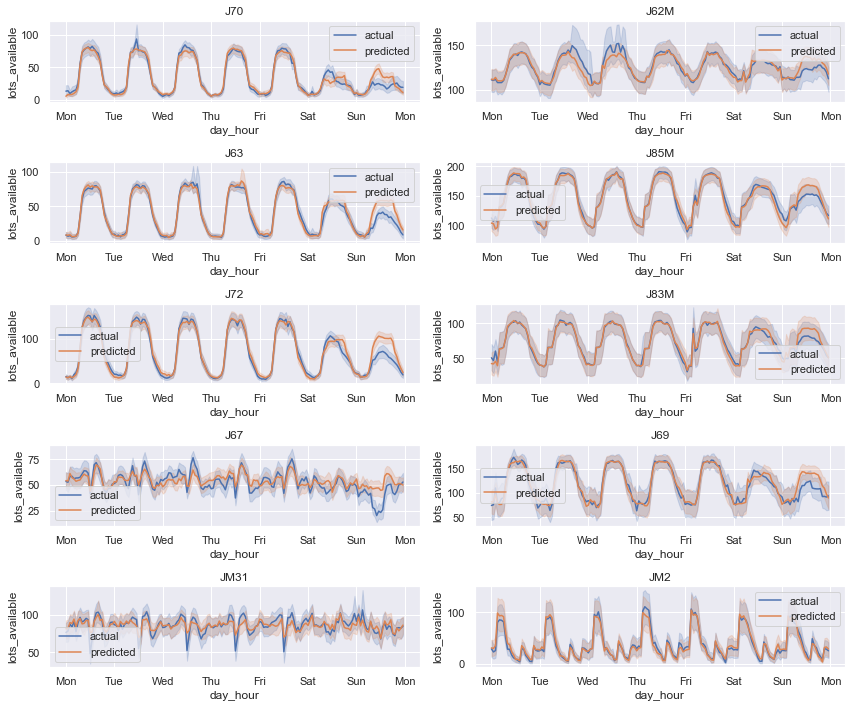

In [11]:
rows = int(len(carpark_arr)/2)
fig, axis = plt.subplots(nrows=rows, ncols=2)
fig.set_size_inches(12, 10)

fig.tight_layout()

i = 0
for carpark in dtreg_predictions.keys():
    dfPlot = dtreg_predictions[carpark]
    dfPlot["day_hour"] = "2022-08-" + (dfPlot['day']+1).astype(str) + " " + dfPlot["hour"].astype(str) + ":0:0"
    dfPlot["day_hour"] = pd.to_datetime(dfPlot["day_hour"], format= "%Y-%m-%d %H:%M:%S")
    date_format =  mdates.DateFormatter("%a")
    lp1 = sb.lineplot(x='day_hour',y='lots_available', legend='brief', label="actual",data=dfPlot, ax=axis[i%rows,i%2])
    lp2 = sb.lineplot(x='day_hour',y='predicted_lots', legend='brief', label="predicted",data=dfPlot, ax=axis[i%rows,i%2])
    lp1.set(title=str(carpark_arr[i]))
    lp1.xaxis.set_major_formatter(date_format)
    lp2.xaxis.set_major_formatter(date_format)
    
    i = i + 1
fig.tight_layout()

In [12]:
for carpark in dtreg_predictions.keys():
    print()
    print(carpark)
    print(dtreg_predictions[carpark])
    type(dtreg_predictions[carpark])


J70
      day  hour  hour_delta  lots_available  predicted_lots  \
0       0     0       336.0             0.0           0.396   
1       0     0      2520.0            11.0           1.364   
2       0     0      2856.0            11.0           0.644   
3       0     0      3024.0             0.0           4.178   
4       0     0      5208.0             0.0           0.108   
...   ...   ...         ...             ...             ...   
6875    6    23     31415.0             0.0           0.122   
6876    6    23     32087.0             0.0           0.226   
6877    6    23     32423.0             0.0           0.006   
6878    6    23     34103.0             0.0           0.522   
6879    6    23     34439.0             0.0           0.286   

                day_hour  
0    2022-08-01 00:00:00  
1    2022-08-01 00:00:00  
2    2022-08-01 00:00:00  
3    2022-08-01 00:00:00  
4    2022-08-01 00:00:00  
...                  ...  
6875 2022-08-07 23:00:00  
6876 2022-08-07 23:00:

In [13]:
# df for predictions of 5 Jan 2022
prediction_df = pd.DataFrame()

for carpark in dtreg_predictions.keys():

#     print(carpark)
    trainX = df[df['carpark_number'] == carpark]
    trainY = df[df['carpark_number'] == carpark]

    trainX = trainX[['day','hour','hour_delta']]
    trainY = trainY['lots_available'].values

    dtreg =  RandomForestRegressor(n_estimators = 500, random_state = 0)
    rfrModel = dtreg.fit(trainX, np.ravel(trainY))


    predictions = []

    for i in range(24):
        predictions.append(rfrModel.predict([[2, i, 35160 + i]])[0])

    prediction_df[carpark] = predictions

    
    
    
    
    

In [14]:
print("The following are the predictions for the whole day of 5th January 2022 from our data:")
prediction_df

The following are the predictions for the whole day of 5th January 2022 from our data:


,J70,J85M,J72,J69,JM31,J62M,J63,J83M,J67,JM2
0,0.020000,92.004000,4.207133,25.390000,113.297333,135.057517,0.850500,0.000000,9.557786,149.908000
1,0.020000,88.667333,4.177133,23.878000,112.317833,134.514017,0.265848,0.000000,7.993119,151.582000
2,0.020000,86.982910,4.131133,26.034200,112.203000,134.314683,0.219181,0.000000,5.620452,153.518000
3,0.026000,86.421176,4.221800,26.026500,111.979167,134.804183,0.251281,0.000000,3.625952,224.134971
4,0.020000,86.678010,4.431267,26.446500,111.791167,134.969683,1.086667,0.004000,3.474286,223.455976
5,6.712000,87.801267,6.970400,30.668000,111.724667,135.062767,7.312000,0.000000,1.712833,223.444743
6,5.580000,92.340000,12.412000,37.086000,111.357667,135.235767,10.266000,0.030000,1.524833,208.070000
7,29.502000,110.310000,31.458000,69.318000,112.063833,140.176000,25.510000,11.720000,1.360833,186.898000
8,41.496333,137.083000,77.156000,106.657500,110.750500,149.819333,52.947167,38.848500,5.150000,108.797000
9,54.142833,163.094000,106.693600,123.818000,115.851833,161.792000,76.440000,53.602000,7.328000,103.846000
